
Objective: Load and clean League of Legends game data to identify important 
    game features that contribute and predict game outcome. This is important 
    because the goal of many players is to identify aspects of the game to improve
    on and the analyses outlined below is generalizable to all skill-based games
    and sports.
    
Data from: https://github.com/DoransLab/data/tree/master/champion_clustering

author: Zhe Charles Zhou


In [1]:

#### Import toolboxes

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:

#### Load data

data=pd.read_csv("C:\\Users\\Zhe\\Documents\\DataScienceProjects\\NYPD_Collisions\\totalSup.csv")


Let's clean up the data and split into feature (independent) and outcome (dependent) variables. Since there are many feature variables, to prevent overfitting, we will a piori select a group of variables that would likely contribute to determining win/loss (outcome variable).

In [3]:
# make the column names reference-friendly
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')
print(data.columns)

Index(['true_role', 'champion_name', 'participant_id', 'match_id',
       'match_rank_score', 'account_id', 'champion_id', 'win',
       'companion_score', 'split_score', 'rotation_score', 'gold_earned',
       'kills', 'deaths', 'assists', 'total_minions_killed',
       'neutral_minions_killed', 'neutral_minions_killed_team_jungle',
       'neutral_minions_killed_enemy_jungle', 'wards_placed', 'wards_killed',
       'damage_self_mitigated', 'total_damage_taken',
       'damage_dealt_to_objectives', 'damage_dealt_to_turrets',
       'magic_damage_dealt_to_champions', 'physical_damage_dealt_to_champions',
       'true_damage_dealt_do_dhampions', 'total_heal', 'time_ccing_others',
       'percent_taken', 'total_damage_dealt_to_champions', 'percent_magic',
       'kda', 'max_time'],
      dtype='object')


In [6]:
# separate category and feature data
dataX_all=data.drop('win',axis=1)
dataY=data['win']

# define columns to analyze
columns2Keep = ['champion_name','match_rank_score','companion_score','gold_earned','wards_placed','damage_dealt_to_objectives','damage_dealt_to_turrets','kda','total_damage_dealt_to_champions']
dataX = dataX_all[columns2Keep]

Logistic regression Data Preprocessing. Our first step is to map the categorical variable to binary values using one-hot-encoding and to scale the continuous data.

In [7]:
# Define which columns should be encoded vs scaled
columns_to_encode = ['champion_name']
columns_to_scale  = ['match_rank_score','companion_score','gold_earned','wards_placed','damage_dealt_to_objectives','damage_dealt_to_turrets','kda','total_damage_dealt_to_champions']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(dataX[columns_to_scale]) 
encoded_columns =    ohe.fit_transform(dataX[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
processedX = np.concatenate([scaled_columns, encoded_columns], axis=1)


In [8]:
# from scikitlearn: split data into test and training sets
xTrain,xTest,yTrain,yTest=train_test_split(processedX,dataY,test_size=0.2,random_state=42)


Build the Logistic regression

In [9]:
parameters=[
{
    'penalty':['l1','l2'],
    'C':[0.1,0.4,0.5,1],
    'random_state':[0]
    },
]

logOptimal = GridSearchCV(LogisticRegression(), parameters, scoring='accuracy')
logOptimal.fit(xTrain, yTrain)
print('Best parameters set:')
print(logOptimal.best_params_)

Best parameters set:
{'C': 1, 'penalty': 'l1', 'random_state': 0}


In [10]:
pred = logOptimal.predict(xTest)

from sklearn.metrics import accuracy_score
print('Optimized logistic regression performance: ',
      round(accuracy_score(yTest,pred),5)*100,'%')

Optimized logistic regression performance:  83.11500000000001 %


Examine contribution of variables to win

Text(0.5, 1.0, 'Log Reg Coef Scores')

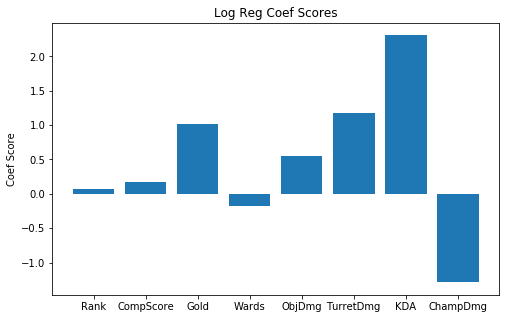

In [12]:
bestLR=LogisticRegression(C=1,penalty='l1',random_state=0)
bestLR.fit(xTrain, yTrain)

logCoefs = bestLR.coef_

x_labels = ['Rank','CompScore','Gold','Wards','ObjDmg','TurretDmg','KDA','ChampDmg']

plt.figure(figsize=(8,5))
plt.bar(columns_to_scale[0:8],logCoefs[0,0:8])
plt.ylabel('Coef Score')
plt.xticks(np.arange(8), x_labels)
plt.title('Log Reg Coef Scores')

Evaluate the model performance plotting the receiver operating characteristic (ROC) curve and calculating the area under the curve (AUC).

In [13]:
# calculate predicted probability
prob = logOptimal.predict_proba(xTest)[:,1]
# calculate true and false pos 
falsePos,truePos,thresh = roc_curve(yTest,prob)
#Calculate area under the curve
AUCscore = roc_auc_score(yTest,prob)

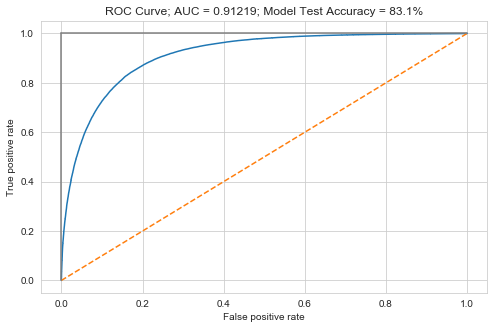

In [14]:
# ROC plot
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))

plt.plot(falsePos,truePos)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')

plt.title('ROC Curve; AUC = ' + str(round(AUCscore,5)) + '; Model Test Accuracy = ' + str(round(accuracy_score(yTest,pred),3)*100) + '%')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()